<a href="https://colab.research.google.com/github/lisalimyxn/DAP-Colour-Analysis/blob/main/Feature_Colour_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install, Mount, Initialize


In [2]:
# 1. Install Facer (wraps FaRL) and Progress Bar
!pip install git+https://github.com/FacePerceiver/facer.git@main tqdm

# 2. Imports
import facer
import torch
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from google.colab import drive

# 3. Mount Drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/ColourAnalysis"

target_image_path = os.path.join(base_path, "dataset/rgb_bg_masked/train/autunno/deep/2025.png")

if os.path.exists(target_image_path):
    print(f"✅ Found target image: {target_image_path}")
else:
    print(f"❌ Image not found at: {target_image_path}")
    print("Please check if 'ColourAnalysis' is directly in MyDrive or inside another folder.")

# Set Up
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} (Make sure this says 'cuda'!)")

face_detector = facer.face_detector('retinaface/mobilenet', device=device)
face_parser = facer.face_parser('farl/lapa/448', device=device)


  Cloning https://github.com/FacePerceiver/facer.git (to revision main) to /tmp/pip-req-build-bewbe88z
  Running command git clone --filter=blob:none --quiet https://github.com/FacePerceiver/facer.git /tmp/pip-req-build-bewbe88z
  Resolved https://github.com/FacePerceiver/facer.git to commit ddd35c76ff840174b8a5403ad1c1255e37b8782b
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00
  Created wheel for pyfacer: filename=pyfacer-0.0.5-py3-none-any.whl size=39543 sha256=c904d8df450c4563dfe58334b79bde181c6571e3b24abe403564bda9dd9afea7
  Stored in directory: /tmp/pip-ephem-wheel-cache-hoasq_q6/wheels/2f/a6/d3/e7ae2f382c9136c349bb06f3a6289b5aea13da153d64191196
Successfully built pyfacer


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Mounted at /content/drive
✅ Found target image: /content/drive/MyDrive/ColourAnalysis/dataset/rgb_bg_masked/train/autunno/deep/2025.png
Using device: cuda (Make sure this says 'cuda'!)
Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /root/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth


100%|██████████| 1.71M/1.71M [00:00<00:00, 206MB/s]
Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.lapa.main_ema_136500_jit191.pt" to /root/.cache/torch/hub/checkpoints/face_parsing.farl.lapa.main_ema_136500_jit191.pt
100%|██████████| 617M/617M [00:17<00:00, 36.9MB/s]


# Testing extraction on 1 image
## Extraction Function

In [4]:

def extract_facial_features_and_colors(image_path):

# 1. Load image
  img_tensor = facer.read_hwc(image_path).to(device)
  img_batch = facer.hwc2bchw(img_tensor).to(device)  # Add batch dimension

  print(f"Processing image...")

  with torch.inference_mode():
    faces = face_detector(img_batch)
    if len(faces['rects']) == 0:
      return None, "No face detected."

        # Parse face features
    faces = face_parser(img_batch, faces)

        # Get segmentation map (each pixel gets a label ID)
    seg_logits = faces['seg']['logits']
    seg_labels = seg_logits.argmax(dim=1).squeeze().cpu().numpy()

# 2. Features we care about
    feature_map = {
        'Skin': [1],        # Label 1: Face Skin
        'Eyebrows': [2, 3], # Labels 2 & 3: Left/Right Eyebrows
        'Eyes': [4, 5],     # Labels 4 & 5: Left/Right Eyes
        'Nose': [6],        # Label 6: Nose
        'Lips': [7, 8, 9],  # Labels 7, 8, 9: Upper lip, Lower lip, Inner mouth
        'Hair': [10]        # Label 10: Hair
    }

    # Prepare image for calculation (H, W, C)
    img_np = img_tensor.cpu().numpy()
    results = {}

# Extract Colors
    plt.figure(figsize=(18, 5))

    # Plot Original
    plt.subplot(1, len(feature_map) + 1, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis('off')

    for i, (feature_name, indices) in enumerate(feature_map.items()):
        # Create a mask: Select pixels that match the feature IDs
        mask = np.isin(seg_labels, indices)

        # Ensure we don't include black pixels (0,0,0)
        # For if segmentation mask spills slightly into the empty background
        non_black_mask = np.any(img_np > 0, axis=-1)
        final_mask = mask & non_black_mask

        feature_pixels = img_np[final_mask]

        if len(feature_pixels) > 0:
            # Calculate Average RGB
            avg_color = np.mean(feature_pixels, axis=0).astype(int)
            results[feature_name] = avg_color

            # Visualization: Show the isolated feature
            masked_img = np.zeros_like(img_np)
            masked_img[final_mask] = img_np[final_mask]

            plt.subplot(1, len(feature_map) + 1, i + 2)
            plt.imshow(masked_img)
            plt.title(f"{feature_name}\n{avg_color}")
            plt.axis('off')
        else:
            results[feature_name] = "Not Found"

    plt.tight_layout()
    plt.show()

    return results, "Success"

### Extraction Test : Train Autunno Deep 2025.png

Analyzing: /content/drive/MyDrive/ColourAnalysis/dataset/rgb_bg_masked/train/autunno/deep/2025.png
Processing image...


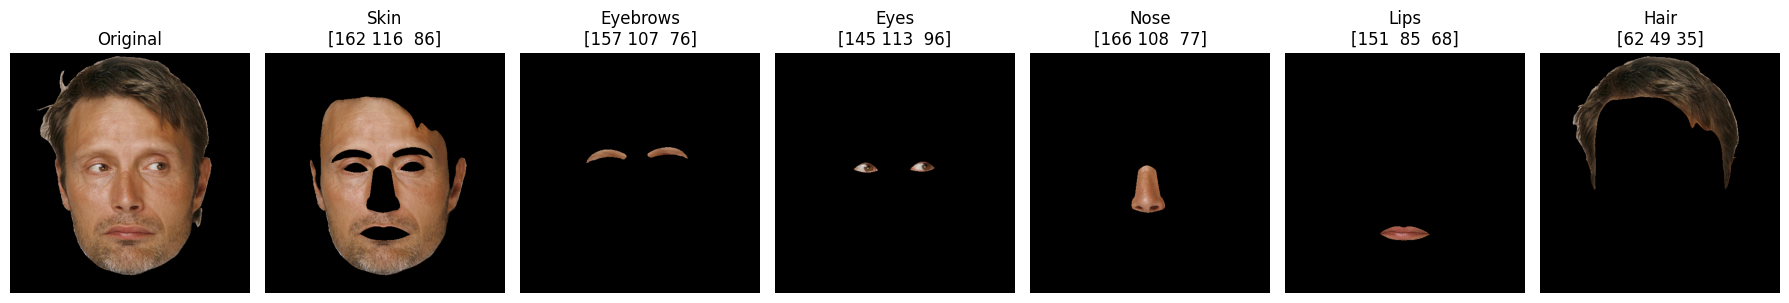


--- Extracted Feature Colors (RGB) ---
Skin      : [162 116  86]
Eyebrows  : [157 107  76]
Eyes      : [145 113  96]
Nose      : [166 108  77]
Lips      : [151  85  68]
Hair      : [62 49 35]


In [5]:
# 1. Define the full path to your image
image_path = "/content/drive/MyDrive/ColourAnalysis/dataset/rgb_bg_masked/train/autunno/deep/2025.png"

# 2. Run the extraction
print(f"Analyzing: {image_path}")
colors, status = extract_facial_features_and_colors(image_path)

# 3. Print Final Data
if colors:
    print("\n--- Extracted Feature Colors (RGB) ---")
    for feature, rgb in colors.items():
        print(f"{feature.ljust(10)}: {rgb}")
else:
    print(f"Error: {status}")

# Adjusting mask boundary, erosion, and median sampling (To reduce concern of colour pollution and increase accuracy of feature colour extraction)

## Refined Extraction Function

In [12]:
def extract_facial_features_and_colors_refined(image_path):

# 1. Load image
  img_tensor = facer.read_hwc(image_path).to(device)
  img_batch = facer.hwc2bchw(img_tensor).to(device)

  print(f"Processing image...")

  with torch.inference_mode():
    faces = face_detector(img_batch)
    if len(faces['rects']) == 0:
      return None, "No face detected."

        # Parse face features
    faces = face_parser(img_batch, faces)

        # Get segmentation map (each pixel gets a label ID)
    seg_logits = faces['seg']['logits']
    seg_labels = seg_logits.argmax(dim=1).squeeze().cpu().numpy()

# 2. Features Mapping
    feature_map = {
        'Skin': [1],        # Label 1: Face Skin
        'Eyebrows': [2, 3], # Labels 2 & 3: Left/Right Eyebrows
        'Eyes': [4, 5],     # Labels 4 & 5: Left/Right Eyes
        'Nose': [6],        # Label 6: Nose
        'Lips': [7, 8, 9],  # Labels 7, 8, 9: Upper lip, Lower lip, Inner mouth
        'Hair': [10]        # Label 10: Hair
    }

    # Prepare image for calculation (H, W, C)
    img_np = img_tensor.cpu().numpy()
    results = {}

# Extract Colors
    plt.figure(figsize=(18, 5))

    # Plot Original
    plt.subplot(1, len(feature_map) + 1, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis('off')

    for i, (feature_name, indices) in enumerate(feature_map.items()):
        # Create a mask: Select pixels that match the feature IDs
        mask = np.isin(seg_labels, indices)

        # Ensure we don't include black pixels (0,0,0)
        # For if segmentation mask spills slightly into the empty background
        non_black_mask = np.any(img_np > 0, axis=-1)
        final_mask = mask & non_black_mask

# --- FIX 1: EROSION (Remove Dark Edges) ---
        # Shrinks mask to remove background shadows
        kernel = np.ones((3, 3), np.uint8)
        final_mask = cv2.erode(final_mask.astype(np.uint8), kernel, iterations=2).astype(bool)

        # --- FIX 2: CROP (Avoid Beard) ---
        if feature_name == 'Skin':
            coords = np.argwhere(final_mask)
            if len(coords) > 0:
                y_min, x_min = coords.min(axis=0)
                y_max, x_max = coords.max(axis=0)
                # Keep only the top 60% of the skin area
                face_limit = y_min + int((y_max - y_min) * 0.6)
                final_mask[face_limit:, :] = False

        # --- FIX 3: IRIS ONLY (Colored part minus Pupil and Sclera) ---
        if feature_name == 'Eyes':
            coords = np.argwhere(final_mask)
            if len(coords) > 0:
                eye_pixels = img_np[final_mask]

                # 1. Calculate brightness (Greyscale intensity)
                # This helps us identify 'White' vs 'Dark' vs 'Colored'
                brightness = np.mean(eye_pixels, axis=1)

                # 2. SCLERA FILTER: Remove the brightest 30%
                # This removes the white of the eyes that dilutes your color data.
                iris_candidate_mask = brightness < np.percentile(brightness, 70)

                # 3. PUPIL FILTER: Remove the darkest 20%
                # This removes the black pupil from the center of the iris.
                is_not_pupil = brightness > np.percentile(brightness, 20)

                # Combine filters to isolate the "Colored Ring"
                iris_pixels = eye_pixels[iris_candidate_mask & is_not_pupil]

                if len(iris_pixels) > 0:
                    feature_pixels = iris_pixels
                else:
                    feature_pixels = eye_pixels # Fallback if filters are too aggressive
            else:
                feature_pixels = []

        feature_pixels = img_np[final_mask]

        if len(feature_pixels) > 0:
            # Using MEDIAN to ignore stray hair/highlights for a purer color
            avg_color = np.median(feature_pixels, axis=0).astype(int)
            results[feature_name] = avg_color

            # Visualization: Show the isolated feature
            masked_img = np.zeros_like(img_np)
            masked_img[final_mask] = img_np[final_mask]

            plt.subplot(1, len(feature_map) + 1, i + 2)
            plt.imshow(masked_img)
            plt.title(f"{feature_name}\n{avg_color}")
            plt.axis('off')
        else:
            results[feature_name] = "Not Found"

    plt.tight_layout()
    plt.show()

    return results, "Success"

Analyzing: /content/drive/MyDrive/ColourAnalysis/dataset/rgb_bg_masked/train/autunno/deep/2025.png
Processing image...


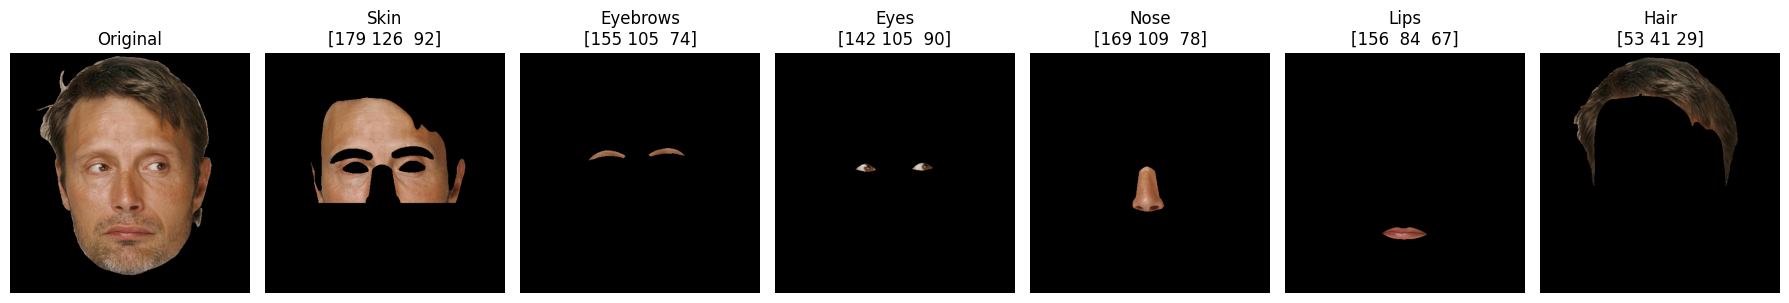


--- Extracted Feature Colors (RGB) ---
Skin      : [179 126  92]
Eyebrows  : [155 105  74]
Eyes      : [142 105  90]
Nose      : [169 109  78]
Lips      : [156  84  67]
Hair      : [53 41 29]


In [13]:
# 1. Define the full path to your image
image_path = "/content/drive/MyDrive/ColourAnalysis/dataset/rgb_bg_masked/train/autunno/deep/2025.png"

# 2. Run the extraction
print(f"Analyzing: {image_path}")
colors, status = extract_facial_features_and_colors_refined(image_path)

# 3. Print Final Data
if colors:
    print("\n--- Extracted Feature Colors (RGB) ---")
    for feature, rgb in colors.items():
        print(f"{feature.ljust(10)}: {rgb}")
else:
    print(f"Error: {status}")

# Final Extraction of Entire Dataset (Refined)

Set Up (Function for refined extraction)

In [3]:
def extract_essential_features(img_tensor, seg_labels):
    """Refined extraction for Skin, Eyes, and Lips only."""
    results = {'Skin': None, 'Eyes': None, 'Lips': None}
    img_np = img_tensor.cpu().numpy() if torch.is_tensor(img_tensor) else img_tensor

    # Ensure seg_labels is 2D (H, W)
    if seg_labels.ndim > 2:
        seg_labels = seg_labels.squeeze()

    non_black_mask = np.any(img_np > 0, axis=-1)
    kernel = np.ones((3, 3), np.uint8)

    # --- SKIN ---
    skin_mask = (seg_labels == 1) & non_black_mask
    # Fix: Ensure mask is uint8 and 2D for cv2.erode
    skin_mask_er = cv2.erode(skin_mask.astype(np.uint8), kernel, iterations=2).astype(bool)

    coords = np.argwhere(skin_mask_er)
    if len(coords) > 0:
        y_min, _ = coords.min(axis=0)
        y_max, _ = coords.max(axis=0)
        forehead_limit = y_min + int((y_max - y_min) * 0.3)
        skin_mask[forehead_limit:, :] = False # Keep top 30%
        pixels = img_np[skin_mask]
        results['Skin'] = np.median(pixels, axis=0).astype(int) if len(pixels) > 0 else None

    # --- EYES: Iris only (minus pupil and whites) ---
    eye_mask = np.isin(seg_labels, [4, 5]) & non_black_mask
    eye_mask = cv2.erode(eye_mask.astype(np.uint8), kernel, iterations=1).astype(bool)
    eye_pixels = img_np[eye_mask]
    if len(eye_pixels) > 0:
        brightness = np.mean(eye_pixels, axis=1)
        iris_mask = (brightness > np.percentile(brightness, 20)) & (brightness < np.percentile(brightness, 70))
        iris_pixels = eye_pixels[iris_mask]
        results['Eyes'] = np.median(iris_pixels, axis=0).astype(int) if len(iris_pixels) > 0 else None

    # --- LIPS: Pure color only ---
    lip_mask = np.isin(seg_labels, [7, 8, 9]) & non_black_mask
    lip_mask = cv2.erode(lip_mask.astype(np.uint8), kernel, iterations=2).astype(bool)
    lip_pixels = img_np[lip_mask]
    results['Lips'] = np.median(lip_pixels, axis=0).astype(int) if len(lip_pixels) > 0 else None

    return results

### Feature Colour Extraction of rgb_bg_masked (Iteration Loop)

Colours saved in feature_colours.csv. 'None' indicated if feature is obstructed / unable to be detected.

In [ ]:
# 1. Define Paths
ROOT_PATH = "/content/drive/MyDrive/ColourAnalysis/dataset/rgb_bg_masked"
SAVE_CSV = "/content/drive/MyDrive/ColourAnalysis/dataset/feature_colours.csv"
ERROR_CSV = "/content/drive/MyDrive/ColourAnalysis/dataset/failed_images.txt"

# 2. Collect tasks for both partitions
image_tasks = []
partitions = ['train', 'test']
classes = ['autunno', 'estate', 'inverno', 'primavera']

for part in partitions:
    part_dir = os.path.join(ROOT_PATH, part)
    if not os.path.exists(part_dir): continue

    for cls in classes:
        cls_dir = os.path.join(part_dir, cls)
        if not os.path.exists(cls_dir): continue

        for sub in os.listdir(cls_dir):
            sub_dir = os.path.join(cls_dir, sub)
            if not os.path.isdir(sub_dir): continue

            for img in os.listdir(sub_dir):
                if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_tasks.append({
                        'filename': img,
                        'partition': part,
                        'class': cls,
                        'sub_class': sub,
                        'full_path': os.path.join(sub_dir, img)
                    })

# 3. Run Loop
print(f"🚀 Starting extraction for {len(image_tasks)} images...")
final_results = []
failed_images = []

for i, task in enumerate(tqdm(image_tasks)):
        # GPU Optimized loading
    try:
        img_tensor = facer.read_hwc(task['full_path']).to(device)
        img_batch = facer.hwc2bchw(img_tensor)

        with torch.inference_mode():
            faces = face_detector(img_batch)
            if not faces or len(faces['rects']) == 0:
              failed_images.append({**task, 'error_reason': 'No Face Detected'})
              continue

            faces = face_parser(img_batch, faces)
            seg_labels = faces['seg']['logits'].argmax(dim=1).squeeze().cpu().numpy()

        # Extract & Store
        colors = extract_essential_features(img_tensor.cpu().numpy(), seg_labels)
        row = {'filename': task['filename'], 'partition': task['partition'], 'class': task['class'], 'sub_class': task['sub_class']}

        missing = [feat for feat, val in colors.items() if val is None]

        if missing:
          failed_images.append({**task, 'error_reason': f"Missing: {', '.join(missing)}"})
          for part, rgb in colors.items():
            row[f'{part}_R'], row[f'{part}_G'], row[f'{part}_B'] = 'None', 'None', 'None'

        else:
          for part, rgb in colors.item():
            row[f'{part}_R'], row[f'{part}_G'], row[f'{part}_B'] = rgb

        final_results.append(row)

        # Checkpoint save every 500 images to prevent data loss
        if i % 500 == 0 and i > 0:
            pd.DataFrame(final_results).to_csv(SAVE_CSV, index=False)
            pd.DataFrame(failed_images).to_csv(ERROR_CSV, index=False)

        del img_tensor, img_batch, faces # Clear GPU memory

    except Exception as e:
      failed_images.append({**task, 'error_reason': f"System Error: {str(e)}"})
      continue

# 4. Final Save
pd.DataFrame(final_results).to_csv(SAVE_CSV, index=False)
pd.DataFrame(failed_images).to_csv(ERROR_CSV, index=False)
print(f"✅ Extraction complete!")

🚀 Starting extraction for 4920 images...


 12%|█▏        | 576/4920 [32:01<15:34:37, 12.91s/it]